In [8]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
from IPython.display import Image
#import winsound
#from playsound import playsound

In [9]:
IMG_SIZE = (34, 26)

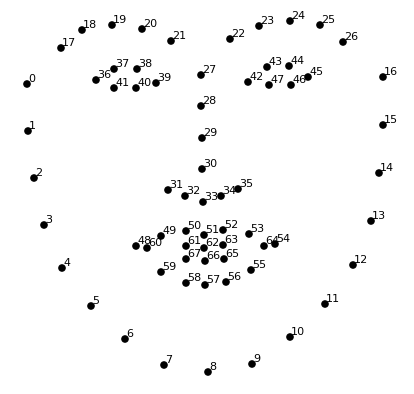

In [10]:
detector = dlib.get_frontal_face_detector()#기본으로 제공되는 얼굴인식모델
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')#얼굴 랜드마크(68개지점 탐지)
Image("68.png")

In [4]:
model = load_model('models/eyemodel.h5')# 과거 학습시킨모델
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 4, 128)         0   

In [5]:
def crop_eye(img, eye_points):#눈 위치 찾음
    x1, y1 = np.amin(eye_points, axis=0)#수평방향중 최소 x,y
    x2, y2 = np.amax(eye_points, axis=0)#수평방향중 최대 x,y
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2 #눈 중심

    w = (x2 - x1) * 1.2#눈 영역의 가로크기
    h = w * IMG_SIZE[1] / IMG_SIZE[0]#눈 영역의 세로크기

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

In [20]:
# main

cap = cv2.VideoCapture(1)#웹캠

eye_q = np.zeros(50, dtype = int)#큐 크기 50
eye_q = eye_q.tolist()
state_threshold = 0.3#눈을 감았다고 판단하는 임계치
width=640
height=480
while cap.isOpened():
    ret, img_ori = cap.read()

    if not ret:#동영상 파일에서 읽어올 프레임이 없으면 종료
        break
    

    img_ori = cv2.resize(img_ori, dsize=(width,height), fx=0.5, fy=0.5)#영상 크기 축소
    
    

    img = img_ori.copy()#원본 이미지를 img_ori 변수에 저장
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#bgr영상을 gray로 변환

    faces = detector(gray)

    for face in faces:
        shapes = predictor(gray, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])#왼쪽 눈 이미지
        eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])#오른쪽 눈 이미지

        eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)#왼쪽 눈 크기 조절
        eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)#오른쪽 눈 크기 조절
        eye_img_r = cv2.flip(eye_img_r, flipCode=1)#오른쪽 눈 좌우반전


        eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
        eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

        pred_l = model.predict(eye_input_l)
        pred_r = model.predict(eye_input_r)

        # visualize
        state_l = 'O' if pred_l > 0.3 else '-'# 'O':눈을 뜬 경우/ '-':눈을 감은 경우
        state_r = 'O' if pred_r > 0.3 else '-'

     

        # perclos
        if(pred_l<0.3 and  pred_r<0.3):# 양쪽 눈을 감았다고 판단한 경우
            flag=1
        else:# 양쪽 눈을 떴거나 한 쪽 눈만 떴다고 판단한 경우
            flag=0
        eye_q = eye_q[1:len(eye_q)] + [flag] # queue에 flag값을 삽입

        perclos = ((sum(eye_q) / len(eye_q)) * 100)#perclos계산 ((눈을 감은 누적된 시간/측정시간)x100)

        if perclos >= 40:#눈을 감은 누적시간 판단기준 40
            cv2.putText(img, "Wake up!!",(int((width/2)-45),int(height/5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)#졸음으로 판단되면 Wake up 경고 메세지 출력
            #winsound.PlaySound("*", winsound.SND_ALIAS)# 소리경고
            #playsound("alarm.mp3") 
        
        cv2.putText(img, "Perclos:%.1f"%perclos,(30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)#현재 perclos 수치 띄우기
        cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255, 255, 255), thickness=2)# 왼쪽 눈에 박스 씌우기
        cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255, 255, 255), thickness=2)# 오른쪽 눈에 박스 씌우기

        cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)# 현재 왼쪽 눈 상태 기호 출력
        cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)# 현재 오른쪽 눈 상태 

    cv2.imshow('result',img)
    

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


<ipython-input-5-84d8d2982ef4>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)
